In [67]:
import cv2
import numpy as np
import os
import time
import scipy.io as sio
import matplotlib.pyplot as plt
import math
# import main_functions as main

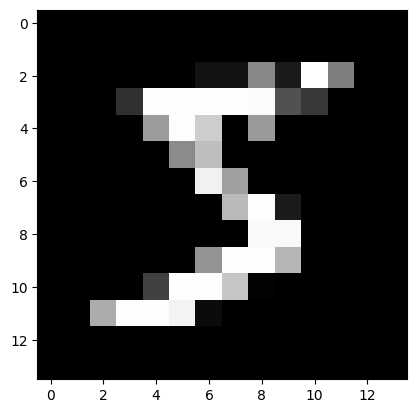

In [68]:
## Add for Visualization.
mnist_train = sio.loadmat('./mnist_train.mat')
mnist_test = sio.loadmat('./mnist_test.mat')
im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
im_test, label_test = mnist_test['im_test'], mnist_test['label_test']

np.random.seed(42)

plt.imshow(mnist_train['im_train'][:, 0].reshape((14, 14), order='F'), cmap='gray')

In [143]:
def get_mini_batch(im_train, label_train, batch_size):
    # TO DO
    ## One hot encode the labels.
    label_train_encoded = np.eye(10)[label_train[0]].T

    ## Get shuffled indices.
    np.random.seed(39)
    random_indices = np.random.permutation(label_train.shape[1])

    ## Get the Mini Batches, numpy automatically takes care of the last batch
    mini_batch_x = [im_train[:,random_indices[i*batch_size:(i+1)*batch_size]] for i in range(math.ceil(im_train.shape[1]/batch_size))]
    mini_batch_y = [label_train_encoded[:,random_indices[i*batch_size:(i+1)*batch_size]] for i in range(math.ceil(im_train.shape[1]/batch_size))]
    
    return mini_batch_x, mini_batch_y

In [70]:
def fc(x, w, b):
    # TO DO
    y = w@x + b
    return y

In [71]:
def fc_backward(dl_dy, x, w, b, y):
    # TO DO
    dl_dw = dl_dy @ x.T
    dl_db = dl_dy
    dl_dx = w.T @ dl_dy
    
    return dl_dx, dl_dw, dl_db

In [72]:
def loss_euclidean(y_tilde, y):
    # TO DO
    l = np.sum(np.square(y_tilde - y))
    dl_dy = 2*(y_tilde - y)
    
    return l, dl_dy

In [163]:
def loss_cross_entropy_softmax(x, y):
    # TO DO

    ## Apply Softmax layer.
    y_telda = np.exp(x)/np.sum(np.exp(x))

    # Get the solfmax loss.
    l = -np.sum(y*np.log(y_telda))

    # Gradient of loss wrt prediction.
    dl_dy_telda = -y/y_telda

    # Gradient of loss wrt input x.
    class_index = np.argmax(y == 1)   ## Return a array.
    f_i = y_telda[class_index]

    dy_dx = -y_telda*f_i
    dy_dx[class_index] = f_i * (1 - f_i)

    ## Set the return value.
    dl_dy = dl_dy_telda*dy_dx
    # print("Shape of dl_dy : ", dl_dy.shape)
    return l, dl_dy

In [74]:
def relu(x):
    # TO DO
    x[x < 0] = 0
    y = x
    return y

In [75]:
def relu_backward(dl_dy, x, y):
    # TO DO
    return dl_dx

In [76]:
def conv(x, w_conv, b_conv):
    # TO DO
    return y

In [77]:
def conv_backward(dl_dy, x, w_conv, b_conv, y):
    # TO DO
    return dl_dw, dl_db

In [78]:
def pool2x2(x):
    # TO DO
    return y

In [79]:
def pool2x2_backward(dl_dy, x, y):
    # TO DO
    return dl_dx

In [80]:
def flattening(x):
    # TO DO
    return y

In [81]:
def flattening_backward(dl_dy, x, y):
    # TO DO
    return dl_dx

In [88]:
def train_slp_linear(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 0.1
    decay_rate = 0.5

    ## Initialize Weights.
    input_size = mini_batch_x[0].shape[0]
    output_size = mini_batch_y[0].shape[0]
    w = np.random.randn(output_size,input_size)
    b = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(10000):
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate
        dl_dw_batch = np.zeros_like(w)
        dl_db_batch = np.zeros_like(b)
        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)

            ## Forward pass.
            y_tilde = fc(x, w, b)

            ## Compute Loss.
            loss, dl_dy = loss_euclidean(y_tilde, y)   ## dl_dy is columns

            ## Compute Gradients.
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, x, w, b, y)

            ## Add to the gradients of batch.
            dl_dw_batch += dl_dw
            dl_db_batch += dl_db
            loss_cum += loss

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w -= (learning_rate/len(mini_batch_x[0]))*dl_dw_batch
        b -= (learning_rate/len(mini_batch_x[0]))*dl_db_batch
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    return w, b

In [164]:
def train_slp(mini_batch_x, mini_batch_y):
    # TO DO
    learning_rate = 1
    decay_rate = 0.7

    ## Initialize Weights.
    input_size = mini_batch_x[0].shape[0]
    output_size = mini_batch_y[0].shape[0]
    w = np.random.randn(output_size,input_size)
    b = np.random.randn(output_size,1)

    k = 0
    losses = []
    for iter in range(1001):
        if iter%1000 == 0:
            print("Iteration Number is : ", iter, " Loss is : ", losses[-1] if len(losses) > 0 else 0)
            learning_rate = learning_rate*decay_rate
        dl_dw_batch = np.zeros_like(w)
        dl_db_batch = np.zeros_like(b)
        loss_cum = 0
        for x, y in zip(mini_batch_x[k].T, mini_batch_y[k].T):
            x = x.reshape(-1,1)
            y = y.reshape(-1,1)

            ## Forward pass.
            y_tilde = fc(x, w, b)

            ## Compute Loss.
            loss, dl_dy = loss_cross_entropy_softmax(y_tilde, y)   ## dl_dy is columns

            ## Compute Gradients.
            dl_dx, dl_dw, dl_db = fc_backward(dl_dy, x, w, b, y)

            ## Add to the gradients of batch.
            dl_dw_batch += dl_dw
            dl_db_batch += dl_db
            loss_cum += loss
        #     break
        # break

        losses.append(loss_cum)
        k += 1
        if k == len(mini_batch_x):
            k = 0
        ## Update weights
        w -= (learning_rate/len(mini_batch_x[0]))*dl_dw_batch
        b -= (learning_rate/len(mini_batch_x[0]))*dl_db_batch
    plt.plot(np.arange(len(losses)), losses)
    plt.show()
    return w, b

Iteration Number is :  0  Loss is :  0
Iteration Number is :  1000  Loss is :  27.126481669826926


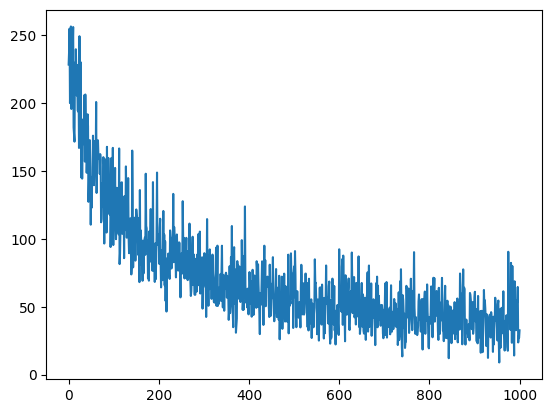

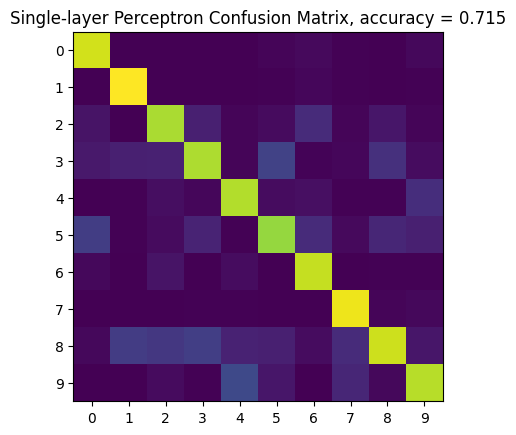

In [165]:
if __name__ == '__main__':
    # main_slp_linear()
    main_slp()
    # main_mlp()
    # main_cnn()

In [ ]:
def train_mlp(mini_batch_x, mini_batch_y):
    # TO DO
    return w1, b1, w2, b2

In [ ]:
def train_cnn(mini_batch_x, mini_batch_y):
    # TO DO
    return w_conv, b_conv, w_fc, b_fc

In [83]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
# from cnn import get_mini_batch, fc, relu, conv, pool2x2, flattening
# from cnn import train_slp_linear, train_slp, train_mlp, train_cnn


def main_slp_linear():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp_linear(mini_batch_x, mini_batch_y)
    sio.savemat('slp_linear.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        y = fc(x, w, b)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Linear Perceptron Confusion Matrix')

def main_slp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w, b = train_slp(mini_batch_x, mini_batch_y)
    sio.savemat('slp.mat', mdict={'w': w, 'b': b})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        y = fc(x, w, b)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Single-layer Perceptron Confusion Matrix')

def main_mlp():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w1, b1, w2, b2 = train_mlp(mini_batch_x, mini_batch_y)
    sio.savemat('mlp.mat', mdict={'w1': w1, 'b1': b1, 'w2': w2, 'b2': b2})

    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]]
        pred1 = fc(x, w1, b1)
        pred2 = relu(pred1)
        y = fc(pred2, w2, b2)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1

        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'Multi-layer Perceptron Confusion Matrix')

def main_cnn():
    mnist_train = sio.loadmat('./mnist_train.mat')
    mnist_test = sio.loadmat('./mnist_test.mat')
    im_train, label_train = mnist_train['im_train'], mnist_train['label_train']
    im_test, label_test = mnist_test['im_test'], mnist_test['label_test']
    batch_size = 32
    im_train, im_test = im_train / 255.0, im_test / 255.0
    mini_batch_x, mini_batch_y = get_mini_batch(im_train, label_train, batch_size)
    w_conv, b_conv, w_fc, b_fc = train_cnn(mini_batch_x, mini_batch_y)
    sio.savemat('cnn.mat', mdict={'w_conv': w_conv, 'b_conv': b_conv, 'w_fc': w_fc, 'b_fc': b_fc})
    # could use following two lines to replace above two lines if only want to check results
    # data = sio.loadmat('cnn.mat')
    # w_conv, b_conv, w_fc, b_fc = data['w_conv'], data['b_conv'], data['w_fc'], data['b_fc']
    
    acc = 0
    confusion = np.zeros((10, 10))
    num_test = im_test.shape[1]
    for i in range(num_test):
        x = im_test[:, [i]].reshape((14, 14, 1), order='F')
        pred1 = conv(x, w_conv, b_conv)  # (14, 14, 3)
        pred2 = relu(pred1)  # (14, 14, 3)
        pred3 = pool2x2(pred2)  # (7, 7, 3)
        pred4 = flattening(pred3)  # (147, 1)
        y = fc(pred4, w_fc, b_fc)  # (10, 1)
        l_pred = np.argmax(y)
        confusion[l_pred, label_test[0, i]] = confusion[l_pred, label_test[0, i]] + 1
        if l_pred == label_test[0, i]:
            acc = acc + 1
    accuracy = acc / num_test
    for i in range(10):
        confusion[:, i] = confusion[:, i] / np.sum(confusion[:, i])

    label_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    visualize_confusion_matrix(confusion, accuracy, label_classes, 'CNN Confusion Matrix')

def visualize_confusion_matrix(confusion, accuracy, label_classes, name):
    plt.title("{}, accuracy = {:.3f}".format(name, accuracy))
    plt.imshow(confusion)
    ax, fig = plt.gca(), plt.gcf()
    plt.xticks(np.arange(len(label_classes)), label_classes)
    plt.yticks(np.arange(len(label_classes)), label_classes)
    ax.set_xticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.set_yticks(np.arange(len(label_classes) + 1) - .5, minor=True)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.show()


In [ ]:
# if __name__ == '__main__':
#     main.main_slp_linear()
#     main.main_slp()
#     main.main_mlp()
#     main.main_cnn()